# Задание

Контрольное задание  2018
1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц
2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию
3.	Выбрать в качестве основного один из рядов
4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить
5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q
6.	Построить VAR модель
7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

Дополнительно:
8.	Построить модель на нейронных сетях
ание:  Работа выполняется в среде R или Python. Должна содержать графики исходных сигналов и результатов моделирования


## 1.	Найти три любых временных ряда, связанных между собой
Можно Составить портфель из 3 биржевых инструментов, сделать для них выборку биржевых данных за один месяц

[*********************100%***********************]  3 of 3 completed


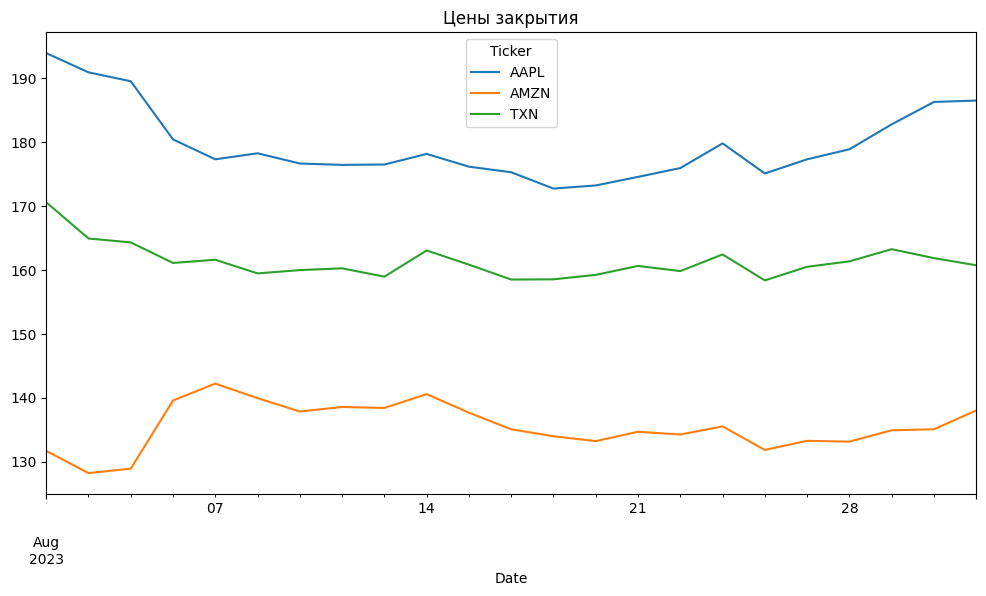

In [4]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
tickers = ['AAPL', 'TXN', 'AMZN']
data = yf.download(tickers, start='2023-08-01', end='2023-09-01')['Close']

# Визуализация
data.plot(figsize=(12, 6))
plt.title('Цены закрытия')
plt.show()

## 2.	Выполнить статистический анализ данных Очистку данных, провести тестирование на стационарность, на коинтеграцию

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2023-08-01 to 2023-08-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    23 non-null     float64
 1   AMZN    23 non-null     float64
 2   TXN     23 non-null     float64
dtypes: float64(3)
memory usage: 736.0 bytes
None


In [14]:
print(data.AAPL.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 23 entries, 2023-08-01 to 2023-08-31
Series name: AAPL
Non-Null Count  Dtype  
--------------  -----  
23 non-null     float64
dtypes: float64(1)
memory usage: 368.0 bytes
None


In [5]:
print(data.isnull().sum())

Ticker
AAPL    0
AMZN    0
TXN     0
dtype: int64


In [15]:
print(data.duplicated().sum())

0


In [16]:
print(data.describe())

Ticker        AAPL        AMZN         TXN
count    23.000000   23.000000   23.000000
mean    179.680442  135.502175  161.312464
std       5.859928    3.612089    2.705425
min     172.733994  128.210007  158.369263
25%     176.049683  133.239998  159.641266
50%     177.310455  135.070007  160.731537
75%     181.601303  138.209999  162.137459
max     193.924896  142.220001  170.591995


In [11]:
print(data.head())

Ticker            AAPL        AMZN         TXN
Date                                          
2023-08-01  193.924896  131.690002  170.591995
2023-08-02  190.920990  128.210007  164.920563
2023-08-03  189.523148  128.910004  164.308487
2023-08-04  180.422241  139.570007  161.094986
2023-08-07  177.309280  142.220001  161.592316


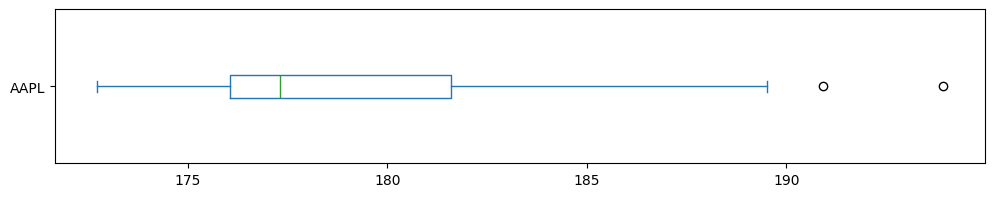

In [22]:
data.AAPL.plot.box(figsize=(12, 2), vert=False);

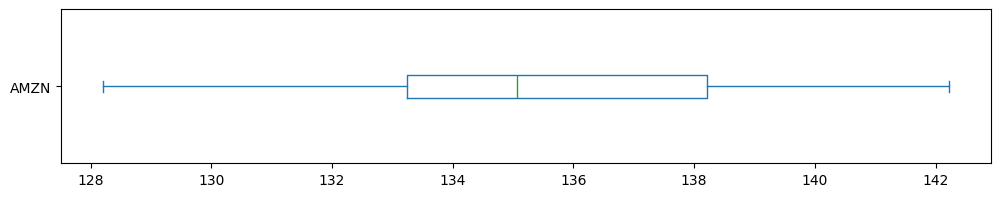

In [23]:
data.AMZN.plot.box(figsize=(12, 2), vert=False);

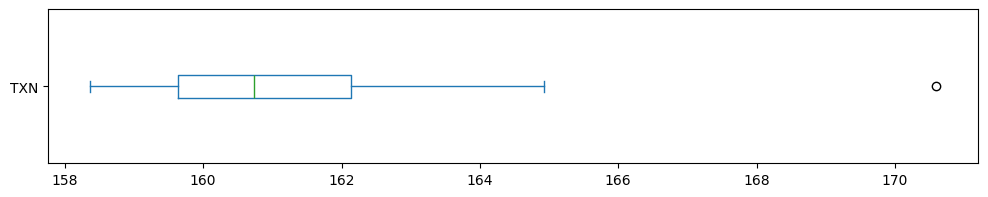

In [24]:
data.TXN.plot.box(figsize=(12, 2), vert=False);

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"Тест Дики-Фуллера для {name}:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Ряд стационарен.")
    else:
        print("Ряд нестационарен.")

for col in data.columns:
    test_stationarity(data[col], col)

Тест Дики-Фуллера для AAPL:
ADF Statistic: -2.464985576658279
p-value: 0.12422776666152918
Ряд нестационарен.
Тест Дики-Фуллера для AMZN:
ADF Statistic: -2.1591053800263036
p-value: 0.22142106272301693
Ряд нестационарен.
Тест Дики-Фуллера для TXN:
ADF Statistic: -5.089963878196703
p-value: 1.468526101271564e-05
Ряд стационарен.


In [25]:
data_diff = data.diff().dropna()

for col in data_diff.columns:
    test_stationarity(data_diff[col], f"{col} (дифференцированный)")

Тест Дики-Фуллера для AAPL (дифференцированный):
ADF Statistic: 0.3548204319987653
p-value: 0.9797244556729533
Ряд нестационарен.
Тест Дики-Фуллера для AMZN (дифференцированный):
ADF Statistic: -0.9653128996950068
p-value: 0.7657045174885551
Ряд нестационарен.
Тест Дики-Фуллера для TXN (дифференцированный):
ADF Statistic: -0.21159988430928314
p-value: 0.9371247433660252
Ряд нестационарен.


In [10]:
from statsmodels.tsa.stattools import coint

def test_cointegration(series1, series2, name1, name2):
    score, p_value, _ = coint(series1, series2)
    print(f"Тест коинтеграции между {name1} и {name2}:")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("Ряды коинтегрированы.")
    else:
        print("Ряды не коинтегрированы.")

# Проверка коинтеграции для всех пар
pairs = [('AAPL', 'TXN'), ('AAPL', 'AMZN'), ('TXN', 'AMZN')]
for pair in pairs:
    test_cointegration(data[pair[0]], data[pair[1]], pair[0], pair[1])

Тест коинтеграции между AAPL и TXN:
p-value: 0.314057567323793
Ряды не коинтегрированы.
Тест коинтеграции между AAPL и AMZN:
p-value: 0.7924931033258575
Ряды не коинтегрированы.
Тест коинтеграции между TXN и AMZN:
p-value: 0.00010719143354837191
Ряды коинтегрированы.


In [26]:
from statsmodels.api import OLS

# Коинтеграционное уравнение
model_ols = OLS(data['AMZN'], data['TXN']).fit()
beta = model_ols.params['TXN']  # Коэффициент β
spread = data['AMZN'] - beta * data['TXN']

test_stationarity(spread, 'Спред TXN-AMZN')

Тест Дики-Фуллера для Спред TXN-AMZN:
ADF Statistic: -3.4591808265382977
p-value: 0.00909942862099642
Ряд стационарен.


In [27]:
data_diff_2 = data_diff.diff().dropna()
for col in data_diff_2.columns:
    test_stationarity(data_diff_2[col], f"{col} (двойное дифференцирование)")

Тест Дики-Фуллера для AAPL (двойное дифференцирование):
ADF Statistic: -3.9595599416051273
p-value: 0.0016377170130337097
Ряд стационарен.
Тест Дики-Фуллера для AMZN (двойное дифференцирование):
ADF Statistic: -0.6194935469416748
p-value: 0.8665161682078557
Ряд нестационарен.
Тест Дики-Фуллера для TXN (двойное дифференцирование):
ADF Statistic: -3.113092845519507
p-value: 0.025599310203622397
Ряд стационарен.


In [29]:
import numpy as np
data_log = np.log(data)
data_log_diff = data_log.diff().dropna()
for col in data_log_diff.columns:
    test_stationarity(data_log_diff[col], f"{col} (логарифм + дифференцирование)")

Тест Дики-Фуллера для AAPL (логарифм + дифференцирование):
ADF Statistic: -3.591600279594035
p-value: 0.005923657833439053
Ряд стационарен.
Тест Дики-Фуллера для AMZN (логарифм + дифференцирование):
ADF Statistic: -0.9672574429651316
p-value: 0.7650183348268134
Ряд нестационарен.
Тест Дики-Фуллера для TXN (логарифм + дифференцирование):
ADF Statistic: -0.19799010945856652
p-value: 0.9387607673579891
Ряд нестационарен.


In [30]:
from statsmodels.api import OLS

def remove_trend(series):
    time_index = np.arange(len(series))
    model = OLS(series, time_index).fit()
    trend = model.predict(time_index)
    return series - trend

data_detrended = data.apply(remove_trend)
for col in data_detrended.columns:
    test_stationarity(data_detrended[col], f"{col} (без тренда)")

Тест Дики-Фуллера для AAPL (без тренда):
ADF Statistic: -2.8392893771506618
p-value: 0.05287701842165882
Ряд нестационарен.
Тест Дики-Фуллера для AMZN (без тренда):
ADF Statistic: -2.6935076146485994
p-value: 0.07516848913745544
Ряд нестационарен.
Тест Дики-Фуллера для TXN (без тренда):
ADF Statistic: -3.0019794026481508
p-value: 0.034709961999960404
Ряд стационарен.


Заменить амазон на что-то иное

## 3.	Выбрать в качестве основного один из рядов

TXN является наиболее подходящим кандидатом для основного ряда, так как он стационарен и имеет долгосрочную связь с AMZN.
AAPL можно использовать как дополнительный ряд для анализа или сравнения.


## 4.	Построить  ARIMA  и ARMAX модель, вывести параметры, сравнить

## 5.	Построить две модели из семейства GARCH, вывести параметры, сравнить при разных p, q

## 6.	Построить VAR модель

## 7.	Построить 2  любых бустинговых модели (XGBoost, ThymeBoost, CatBoost)

## 8.	Построить модель на нейронных сетях